In [35]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
from matplotlib import pyplot


In [19]:
img_cols = 28
img_rows=28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [20]:
def build_generator():

    noise_shape = (100,) 
    model = Sequential()
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)   

    return Model(noise, img)

In [21]:
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [22]:
def train(epochs, batch_size=128, save_interval=50):
    (X_train, _), (_, _) = mnist.load_data()

    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):

        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
 
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)

        
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
  
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

        noise = np.random.normal(0, 1, (batch_size, 100)) 
        
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        g_loss = combined.train_on_batch(noise, valid_y)
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [23]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [29]:
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)


z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)
    
discriminator.trainable = False  


valid = discriminator(img)  

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=4000, batch_size=32, save_interval=10)

generator.save('generator_model.h5')  #Test the model on GAN4_predict...


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

95 [D loss: 0.022703, acc.: 100.00%] [G loss: 4.126096]
96 [D loss: 0.013465, acc.: 100.00%] [G loss: 4.337137]
97 [D loss: 0.017893, acc.: 100.00%] [G loss: 4.168614]
98 [D loss: 0.017257, acc.: 100.00%] [G loss: 4.181089]
99 [D loss: 0.012180, acc.: 100.00%] [G loss: 4.325940]
100 [D loss: 0.026202, acc.: 100.00%] [G loss: 4.353332]
101 [D loss: 0.013227, acc.: 100.00%] [G loss: 4.581017]
102 [D loss: 0.035669, acc.: 100.00%] [G loss: 4.569034]
103 [D loss: 0.029229, acc.: 100.00%] [G loss: 4.547290]
104 [D loss: 0.010902, acc.: 100.00%] [G loss: 4.469994]
105 [D loss: 0.018947, acc.: 100.00%] [G loss: 4.537354]
106 [D loss: 0.015481, acc.: 100.00%] [G loss: 4.571280]
107 [D loss: 0.011244, acc.: 100.00%] [G loss: 4.634484]
108 [D loss: 0.015560, acc.: 100.00%] [G loss: 4.625469]
109 [D loss: 0.017116, acc.: 100.00%] [G loss: 4.501846]
110 [D loss: 0.018532, acc.: 100.00%] [G loss: 4.257746]
111 [D loss: 0.014960, acc.: 100.00%] [G loss: 4.597201]
112 [D loss: 0.014342, acc.: 100.00%

241 [D loss: 0.466099, acc.: 71.88%] [G loss: 2.428020]
242 [D loss: 0.563720, acc.: 68.75%] [G loss: 1.619818]
243 [D loss: 0.450681, acc.: 75.00%] [G loss: 2.497190]
244 [D loss: 0.869873, acc.: 40.62%] [G loss: 1.099121]
245 [D loss: 0.432270, acc.: 78.12%] [G loss: 2.332078]
246 [D loss: 0.542680, acc.: 75.00%] [G loss: 1.843937]
247 [D loss: 0.570302, acc.: 68.75%] [G loss: 1.597005]
248 [D loss: 0.410925, acc.: 78.12%] [G loss: 2.304378]
249 [D loss: 1.115761, acc.: 40.62%] [G loss: 0.706053]
250 [D loss: 0.553710, acc.: 59.38%] [G loss: 1.860299]
251 [D loss: 0.552782, acc.: 68.75%] [G loss: 1.691515]
252 [D loss: 0.749827, acc.: 46.88%] [G loss: 1.423653]
253 [D loss: 0.619196, acc.: 62.50%] [G loss: 1.319651]
254 [D loss: 0.303500, acc.: 100.00%] [G loss: 2.071536]
255 [D loss: 1.024915, acc.: 18.75%] [G loss: 0.707447]
256 [D loss: 0.625171, acc.: 62.50%] [G loss: 1.445942]
257 [D loss: 0.514977, acc.: 68.75%] [G loss: 1.640987]
258 [D loss: 0.666477, acc.: 65.62%] [G loss: 1

389 [D loss: 0.716057, acc.: 40.62%] [G loss: 0.673429]
390 [D loss: 0.698486, acc.: 31.25%] [G loss: 0.676277]
391 [D loss: 0.712367, acc.: 37.50%] [G loss: 0.673217]
392 [D loss: 0.680120, acc.: 50.00%] [G loss: 0.703107]
393 [D loss: 0.683414, acc.: 53.12%] [G loss: 0.690979]
394 [D loss: 0.676779, acc.: 50.00%] [G loss: 0.662519]
395 [D loss: 0.710215, acc.: 46.88%] [G loss: 0.673031]
396 [D loss: 0.667980, acc.: 50.00%] [G loss: 0.690595]
397 [D loss: 0.692107, acc.: 43.75%] [G loss: 0.718969]
398 [D loss: 0.744371, acc.: 31.25%] [G loss: 0.659922]
399 [D loss: 0.663208, acc.: 56.25%] [G loss: 0.633511]
400 [D loss: 0.659917, acc.: 56.25%] [G loss: 0.651208]
401 [D loss: 0.623452, acc.: 56.25%] [G loss: 0.679255]
402 [D loss: 0.686022, acc.: 50.00%] [G loss: 0.681894]
403 [D loss: 0.671651, acc.: 56.25%] [G loss: 0.703237]
404 [D loss: 0.646318, acc.: 59.38%] [G loss: 0.710182]
405 [D loss: 0.685318, acc.: 46.88%] [G loss: 0.724509]
406 [D loss: 0.692143, acc.: 46.88%] [G loss: 0.

537 [D loss: 0.638713, acc.: 59.38%] [G loss: 0.738674]
538 [D loss: 0.671249, acc.: 46.88%] [G loss: 0.718049]
539 [D loss: 0.658642, acc.: 53.12%] [G loss: 0.721785]
540 [D loss: 0.628863, acc.: 56.25%] [G loss: 0.736978]
541 [D loss: 0.673213, acc.: 53.12%] [G loss: 0.717183]
542 [D loss: 0.680572, acc.: 40.62%] [G loss: 0.696673]
543 [D loss: 0.629113, acc.: 59.38%] [G loss: 0.711107]
544 [D loss: 0.667493, acc.: 53.12%] [G loss: 0.729049]
545 [D loss: 0.612779, acc.: 71.88%] [G loss: 0.706198]
546 [D loss: 0.657159, acc.: 56.25%] [G loss: 0.714744]
547 [D loss: 0.673688, acc.: 50.00%] [G loss: 0.705268]
548 [D loss: 0.640210, acc.: 46.88%] [G loss: 0.715132]
549 [D loss: 0.665605, acc.: 53.12%] [G loss: 0.706587]
550 [D loss: 0.696241, acc.: 43.75%] [G loss: 0.663418]
551 [D loss: 0.639496, acc.: 53.12%] [G loss: 0.670258]
552 [D loss: 0.682329, acc.: 62.50%] [G loss: 0.702449]
553 [D loss: 0.650233, acc.: 53.12%] [G loss: 0.724411]
554 [D loss: 0.676240, acc.: 50.00%] [G loss: 0.

685 [D loss: 0.614752, acc.: 78.12%] [G loss: 0.729082]
686 [D loss: 0.644770, acc.: 50.00%] [G loss: 0.752365]
687 [D loss: 0.635909, acc.: 56.25%] [G loss: 0.734310]
688 [D loss: 0.621638, acc.: 68.75%] [G loss: 0.727548]
689 [D loss: 0.631674, acc.: 59.38%] [G loss: 0.742229]
690 [D loss: 0.611433, acc.: 75.00%] [G loss: 0.720844]
691 [D loss: 0.698939, acc.: 71.88%] [G loss: 0.710865]
692 [D loss: 0.656330, acc.: 65.62%] [G loss: 0.689312]
693 [D loss: 0.643106, acc.: 65.62%] [G loss: 0.680821]
694 [D loss: 0.681864, acc.: 53.12%] [G loss: 0.701111]
695 [D loss: 0.672679, acc.: 37.50%] [G loss: 0.687565]
696 [D loss: 0.650807, acc.: 56.25%] [G loss: 0.696803]
697 [D loss: 0.667419, acc.: 62.50%] [G loss: 0.738660]
698 [D loss: 0.677551, acc.: 56.25%] [G loss: 0.737585]
699 [D loss: 0.630891, acc.: 68.75%] [G loss: 0.775764]
700 [D loss: 0.633903, acc.: 62.50%] [G loss: 0.773968]
701 [D loss: 0.624089, acc.: 62.50%] [G loss: 0.761339]
702 [D loss: 0.675182, acc.: 59.38%] [G loss: 0.

833 [D loss: 0.616617, acc.: 78.12%] [G loss: 0.800747]
834 [D loss: 0.638470, acc.: 71.88%] [G loss: 0.784019]
835 [D loss: 0.671782, acc.: 59.38%] [G loss: 0.776084]
836 [D loss: 0.622455, acc.: 71.88%] [G loss: 0.799397]
837 [D loss: 0.600532, acc.: 75.00%] [G loss: 0.779668]
838 [D loss: 0.596369, acc.: 84.38%] [G loss: 0.792670]
839 [D loss: 0.609752, acc.: 71.88%] [G loss: 0.817898]
840 [D loss: 0.634896, acc.: 56.25%] [G loss: 0.844914]
841 [D loss: 0.583474, acc.: 78.12%] [G loss: 0.839904]
842 [D loss: 0.640577, acc.: 65.62%] [G loss: 0.838059]
843 [D loss: 0.620124, acc.: 71.88%] [G loss: 0.870928]
844 [D loss: 0.613936, acc.: 71.88%] [G loss: 0.864871]
845 [D loss: 0.604091, acc.: 81.25%] [G loss: 0.851635]
846 [D loss: 0.603522, acc.: 75.00%] [G loss: 0.843585]
847 [D loss: 0.569989, acc.: 87.50%] [G loss: 0.821851]
848 [D loss: 0.639200, acc.: 68.75%] [G loss: 0.878155]
849 [D loss: 0.599123, acc.: 81.25%] [G loss: 0.856391]
850 [D loss: 0.616918, acc.: 78.12%] [G loss: 0.

981 [D loss: 0.598789, acc.: 78.12%] [G loss: 0.867958]
982 [D loss: 0.656566, acc.: 59.38%] [G loss: 0.812863]
983 [D loss: 0.608582, acc.: 71.88%] [G loss: 0.789201]
984 [D loss: 0.694858, acc.: 46.88%] [G loss: 0.768580]
985 [D loss: 0.622026, acc.: 71.88%] [G loss: 0.773688]
986 [D loss: 0.590743, acc.: 81.25%] [G loss: 0.809230]
987 [D loss: 0.712486, acc.: 46.88%] [G loss: 0.763982]
988 [D loss: 0.610829, acc.: 68.75%] [G loss: 0.764427]
989 [D loss: 0.692055, acc.: 43.75%] [G loss: 0.808131]
990 [D loss: 0.609920, acc.: 75.00%] [G loss: 0.889722]
991 [D loss: 0.602303, acc.: 75.00%] [G loss: 0.925161]
992 [D loss: 0.623357, acc.: 59.38%] [G loss: 0.902799]
993 [D loss: 0.698185, acc.: 53.12%] [G loss: 0.898664]
994 [D loss: 0.583248, acc.: 71.88%] [G loss: 0.925559]
995 [D loss: 0.699392, acc.: 56.25%] [G loss: 0.917051]
996 [D loss: 0.654020, acc.: 46.88%] [G loss: 0.844993]
997 [D loss: 0.664587, acc.: 59.38%] [G loss: 0.755449]
998 [D loss: 0.697315, acc.: 46.88%] [G loss: 0.

1127 [D loss: 0.602047, acc.: 62.50%] [G loss: 0.867612]
1128 [D loss: 0.634738, acc.: 53.12%] [G loss: 0.948464]
1129 [D loss: 0.666594, acc.: 56.25%] [G loss: 0.868740]
1130 [D loss: 0.726361, acc.: 37.50%] [G loss: 0.846320]
1131 [D loss: 0.650212, acc.: 53.12%] [G loss: 0.856173]
1132 [D loss: 0.645981, acc.: 53.12%] [G loss: 0.823009]
1133 [D loss: 0.658995, acc.: 62.50%] [G loss: 0.877314]
1134 [D loss: 0.640487, acc.: 68.75%] [G loss: 0.900250]
1135 [D loss: 0.586458, acc.: 78.12%] [G loss: 0.895945]
1136 [D loss: 0.708868, acc.: 50.00%] [G loss: 0.888332]
1137 [D loss: 0.631124, acc.: 68.75%] [G loss: 0.808563]
1138 [D loss: 0.663073, acc.: 59.38%] [G loss: 0.777046]
1139 [D loss: 0.615276, acc.: 68.75%] [G loss: 0.802503]
1140 [D loss: 0.644330, acc.: 62.50%] [G loss: 0.840406]
1141 [D loss: 0.663929, acc.: 62.50%] [G loss: 0.916681]
1142 [D loss: 0.654792, acc.: 62.50%] [G loss: 0.969770]
1143 [D loss: 0.612440, acc.: 56.25%] [G loss: 0.902443]
1144 [D loss: 0.630231, acc.: 5

1271 [D loss: 0.639703, acc.: 62.50%] [G loss: 0.840820]
1272 [D loss: 0.668478, acc.: 59.38%] [G loss: 0.792137]
1273 [D loss: 0.608638, acc.: 71.88%] [G loss: 0.840922]
1274 [D loss: 0.566098, acc.: 68.75%] [G loss: 0.957740]
1275 [D loss: 0.617311, acc.: 68.75%] [G loss: 0.985081]
1276 [D loss: 0.657025, acc.: 65.62%] [G loss: 0.917412]
1277 [D loss: 0.618347, acc.: 68.75%] [G loss: 0.858209]
1278 [D loss: 0.668315, acc.: 56.25%] [G loss: 0.840222]
1279 [D loss: 0.615225, acc.: 71.88%] [G loss: 0.864952]
1280 [D loss: 0.616432, acc.: 59.38%] [G loss: 0.963430]
1281 [D loss: 0.579210, acc.: 71.88%] [G loss: 0.871016]
1282 [D loss: 0.598220, acc.: 68.75%] [G loss: 0.835496]
1283 [D loss: 0.622278, acc.: 59.38%] [G loss: 0.806512]
1284 [D loss: 0.642015, acc.: 56.25%] [G loss: 0.876853]
1285 [D loss: 0.586700, acc.: 78.12%] [G loss: 0.869181]
1286 [D loss: 0.657534, acc.: 62.50%] [G loss: 0.883893]
1287 [D loss: 0.573755, acc.: 75.00%] [G loss: 0.873899]
1288 [D loss: 0.591516, acc.: 6

1415 [D loss: 0.650843, acc.: 59.38%] [G loss: 0.967363]
1416 [D loss: 0.676562, acc.: 62.50%] [G loss: 0.952237]
1417 [D loss: 0.537992, acc.: 78.12%] [G loss: 0.967975]
1418 [D loss: 0.578101, acc.: 71.88%] [G loss: 0.904751]
1419 [D loss: 0.691191, acc.: 53.12%] [G loss: 0.822151]
1420 [D loss: 0.565635, acc.: 71.88%] [G loss: 0.883634]
1421 [D loss: 0.563652, acc.: 71.88%] [G loss: 0.900310]
1422 [D loss: 0.623972, acc.: 68.75%] [G loss: 0.951883]
1423 [D loss: 0.529895, acc.: 87.50%] [G loss: 0.968068]
1424 [D loss: 0.623699, acc.: 59.38%] [G loss: 0.883741]
1425 [D loss: 0.534644, acc.: 81.25%] [G loss: 0.928322]
1426 [D loss: 0.620390, acc.: 68.75%] [G loss: 0.846361]
1427 [D loss: 0.583588, acc.: 71.88%] [G loss: 0.835586]
1428 [D loss: 0.579633, acc.: 68.75%] [G loss: 0.914464]
1429 [D loss: 0.560358, acc.: 78.12%] [G loss: 0.864853]
1430 [D loss: 0.593552, acc.: 65.62%] [G loss: 0.857462]
1431 [D loss: 0.611594, acc.: 62.50%] [G loss: 0.859473]
1432 [D loss: 0.565587, acc.: 8

1559 [D loss: 0.645605, acc.: 53.12%] [G loss: 0.852933]
1560 [D loss: 0.582037, acc.: 78.12%] [G loss: 0.847187]
1561 [D loss: 0.576882, acc.: 68.75%] [G loss: 0.898461]
1562 [D loss: 0.618712, acc.: 62.50%] [G loss: 0.912859]
1563 [D loss: 0.650379, acc.: 62.50%] [G loss: 0.943272]
1564 [D loss: 0.585552, acc.: 78.12%] [G loss: 0.906965]
1565 [D loss: 0.555535, acc.: 78.12%] [G loss: 0.873996]
1566 [D loss: 0.737021, acc.: 56.25%] [G loss: 0.830924]
1567 [D loss: 0.579404, acc.: 65.62%] [G loss: 0.872920]
1568 [D loss: 0.651887, acc.: 59.38%] [G loss: 0.939676]
1569 [D loss: 0.602535, acc.: 65.62%] [G loss: 0.837719]
1570 [D loss: 0.546087, acc.: 87.50%] [G loss: 0.876925]
1571 [D loss: 0.558162, acc.: 78.12%] [G loss: 0.891236]
1572 [D loss: 0.537161, acc.: 81.25%] [G loss: 0.974635]
1573 [D loss: 0.622303, acc.: 68.75%] [G loss: 0.889818]
1574 [D loss: 0.653804, acc.: 53.12%] [G loss: 0.980465]
1575 [D loss: 0.584275, acc.: 75.00%] [G loss: 0.853171]
1576 [D loss: 0.509349, acc.: 7

1703 [D loss: 0.562535, acc.: 81.25%] [G loss: 0.936968]
1704 [D loss: 0.575070, acc.: 75.00%] [G loss: 0.916901]
1705 [D loss: 0.649711, acc.: 62.50%] [G loss: 0.931634]
1706 [D loss: 0.580022, acc.: 68.75%] [G loss: 0.925349]
1707 [D loss: 0.636072, acc.: 62.50%] [G loss: 0.876415]
1708 [D loss: 0.636453, acc.: 59.38%] [G loss: 0.942586]
1709 [D loss: 0.550889, acc.: 68.75%] [G loss: 0.923347]
1710 [D loss: 0.589956, acc.: 75.00%] [G loss: 0.913547]
1711 [D loss: 0.650644, acc.: 53.12%] [G loss: 0.927770]
1712 [D loss: 0.685256, acc.: 62.50%] [G loss: 0.931621]
1713 [D loss: 0.675214, acc.: 62.50%] [G loss: 0.861720]
1714 [D loss: 0.558443, acc.: 78.12%] [G loss: 0.887158]
1715 [D loss: 0.599579, acc.: 71.88%] [G loss: 0.894773]
1716 [D loss: 0.540624, acc.: 78.12%] [G loss: 0.900130]
1717 [D loss: 0.648551, acc.: 65.62%] [G loss: 0.918123]
1718 [D loss: 0.533521, acc.: 90.62%] [G loss: 0.864789]
1719 [D loss: 0.658398, acc.: 59.38%] [G loss: 0.874783]
1720 [D loss: 0.603486, acc.: 6

1847 [D loss: 0.628109, acc.: 75.00%] [G loss: 0.910212]
1848 [D loss: 0.584885, acc.: 68.75%] [G loss: 0.879359]
1849 [D loss: 0.611054, acc.: 59.38%] [G loss: 0.961939]
1850 [D loss: 0.676014, acc.: 50.00%] [G loss: 0.922887]
1851 [D loss: 0.652283, acc.: 59.38%] [G loss: 0.831649]
1852 [D loss: 0.631914, acc.: 65.62%] [G loss: 0.896493]
1853 [D loss: 0.581381, acc.: 71.88%] [G loss: 0.986027]
1854 [D loss: 0.554399, acc.: 68.75%] [G loss: 1.007323]
1855 [D loss: 0.570665, acc.: 78.12%] [G loss: 1.037605]
1856 [D loss: 0.624914, acc.: 62.50%] [G loss: 1.005255]
1857 [D loss: 0.580628, acc.: 71.88%] [G loss: 1.103728]
1858 [D loss: 0.592316, acc.: 71.88%] [G loss: 1.049390]
1859 [D loss: 0.649018, acc.: 65.62%] [G loss: 0.947815]
1860 [D loss: 0.576047, acc.: 71.88%] [G loss: 0.884452]
1861 [D loss: 0.567840, acc.: 75.00%] [G loss: 0.971038]
1862 [D loss: 0.596581, acc.: 59.38%] [G loss: 0.929262]
1863 [D loss: 0.579040, acc.: 75.00%] [G loss: 0.956640]
1864 [D loss: 0.610943, acc.: 7

1991 [D loss: 0.515022, acc.: 81.25%] [G loss: 0.977270]
1992 [D loss: 0.591854, acc.: 65.62%] [G loss: 0.983528]
1993 [D loss: 0.613515, acc.: 62.50%] [G loss: 1.042076]
1994 [D loss: 0.659485, acc.: 56.25%] [G loss: 0.968735]
1995 [D loss: 0.536367, acc.: 75.00%] [G loss: 0.973420]
1996 [D loss: 0.603049, acc.: 71.88%] [G loss: 0.948203]
1997 [D loss: 0.614321, acc.: 62.50%] [G loss: 0.917470]
1998 [D loss: 0.607731, acc.: 62.50%] [G loss: 1.027128]
1999 [D loss: 0.623388, acc.: 68.75%] [G loss: 1.020789]
2000 [D loss: 0.647512, acc.: 59.38%] [G loss: 0.923969]
2001 [D loss: 0.560935, acc.: 78.12%] [G loss: 1.029618]
2002 [D loss: 0.607160, acc.: 65.62%] [G loss: 0.835427]
2003 [D loss: 0.626207, acc.: 65.62%] [G loss: 0.890427]
2004 [D loss: 0.729427, acc.: 50.00%] [G loss: 0.869847]
2005 [D loss: 0.657941, acc.: 53.12%] [G loss: 0.983095]
2006 [D loss: 0.604656, acc.: 71.88%] [G loss: 0.935658]
2007 [D loss: 0.683430, acc.: 65.62%] [G loss: 0.931854]
2008 [D loss: 0.561083, acc.: 7

2135 [D loss: 0.623800, acc.: 53.12%] [G loss: 1.107958]
2136 [D loss: 0.659403, acc.: 59.38%] [G loss: 1.017219]
2137 [D loss: 0.546061, acc.: 68.75%] [G loss: 1.028806]
2138 [D loss: 0.661990, acc.: 62.50%] [G loss: 1.006049]
2139 [D loss: 0.678720, acc.: 56.25%] [G loss: 0.873309]
2140 [D loss: 0.624594, acc.: 68.75%] [G loss: 0.973660]
2141 [D loss: 0.692909, acc.: 56.25%] [G loss: 0.876123]
2142 [D loss: 0.660929, acc.: 59.38%] [G loss: 0.961493]
2143 [D loss: 0.721646, acc.: 56.25%] [G loss: 0.938430]
2144 [D loss: 0.660475, acc.: 56.25%] [G loss: 0.865215]
2145 [D loss: 0.629492, acc.: 62.50%] [G loss: 0.845911]
2146 [D loss: 0.633775, acc.: 62.50%] [G loss: 0.875735]
2147 [D loss: 0.598595, acc.: 65.62%] [G loss: 0.907517]
2148 [D loss: 0.536877, acc.: 78.12%] [G loss: 0.952382]
2149 [D loss: 0.526303, acc.: 84.38%] [G loss: 1.011834]
2150 [D loss: 0.597682, acc.: 68.75%] [G loss: 0.984942]
2151 [D loss: 0.657887, acc.: 56.25%] [G loss: 0.887273]
2152 [D loss: 0.621267, acc.: 6

2279 [D loss: 0.613832, acc.: 71.88%] [G loss: 0.957989]
2280 [D loss: 0.602884, acc.: 68.75%] [G loss: 0.914799]
2281 [D loss: 0.561761, acc.: 78.12%] [G loss: 1.002090]
2282 [D loss: 0.635159, acc.: 59.38%] [G loss: 0.990739]
2283 [D loss: 0.581865, acc.: 78.12%] [G loss: 1.000601]
2284 [D loss: 0.597907, acc.: 75.00%] [G loss: 1.059858]
2285 [D loss: 0.620001, acc.: 53.12%] [G loss: 1.012259]
2286 [D loss: 0.550876, acc.: 75.00%] [G loss: 1.045400]
2287 [D loss: 0.645520, acc.: 71.88%] [G loss: 0.871756]
2288 [D loss: 0.571422, acc.: 65.62%] [G loss: 0.960317]
2289 [D loss: 0.604060, acc.: 68.75%] [G loss: 1.039814]
2290 [D loss: 0.644261, acc.: 62.50%] [G loss: 1.053400]
2291 [D loss: 0.617753, acc.: 62.50%] [G loss: 1.079554]
2292 [D loss: 0.563147, acc.: 71.88%] [G loss: 1.174427]
2293 [D loss: 0.612511, acc.: 65.62%] [G loss: 0.984780]
2294 [D loss: 0.573215, acc.: 75.00%] [G loss: 0.920387]
2295 [D loss: 0.560416, acc.: 71.88%] [G loss: 0.988841]
2296 [D loss: 0.561431, acc.: 6

2423 [D loss: 0.603783, acc.: 68.75%] [G loss: 0.839664]
2424 [D loss: 0.522428, acc.: 78.12%] [G loss: 0.939639]
2425 [D loss: 0.605656, acc.: 62.50%] [G loss: 0.860207]
2426 [D loss: 0.632760, acc.: 62.50%] [G loss: 0.945854]
2427 [D loss: 0.614801, acc.: 59.38%] [G loss: 0.860646]
2428 [D loss: 0.614178, acc.: 68.75%] [G loss: 0.879197]
2429 [D loss: 0.538834, acc.: 75.00%] [G loss: 0.868318]
2430 [D loss: 0.608355, acc.: 65.62%] [G loss: 0.950446]
2431 [D loss: 0.626416, acc.: 65.62%] [G loss: 0.952753]
2432 [D loss: 0.571452, acc.: 78.12%] [G loss: 1.005977]
2433 [D loss: 0.740486, acc.: 50.00%] [G loss: 0.938018]
2434 [D loss: 0.595321, acc.: 65.62%] [G loss: 1.022868]
2435 [D loss: 0.605741, acc.: 71.88%] [G loss: 1.034620]
2436 [D loss: 0.649742, acc.: 56.25%] [G loss: 0.893978]
2437 [D loss: 0.698047, acc.: 62.50%] [G loss: 0.882279]
2438 [D loss: 0.619290, acc.: 68.75%] [G loss: 0.918348]
2439 [D loss: 0.574184, acc.: 84.38%] [G loss: 1.035002]
2440 [D loss: 0.599940, acc.: 6

2567 [D loss: 0.548878, acc.: 87.50%] [G loss: 0.960160]
2568 [D loss: 0.680265, acc.: 50.00%] [G loss: 0.916570]
2569 [D loss: 0.677175, acc.: 68.75%] [G loss: 0.911616]
2570 [D loss: 0.553469, acc.: 75.00%] [G loss: 1.025783]
2571 [D loss: 0.626166, acc.: 65.62%] [G loss: 0.953873]
2572 [D loss: 0.617533, acc.: 68.75%] [G loss: 0.940149]
2573 [D loss: 0.641731, acc.: 59.38%] [G loss: 0.970105]
2574 [D loss: 0.586053, acc.: 59.38%] [G loss: 1.135509]
2575 [D loss: 0.663258, acc.: 62.50%] [G loss: 1.040571]
2576 [D loss: 0.636694, acc.: 65.62%] [G loss: 0.892103]
2577 [D loss: 0.591627, acc.: 68.75%] [G loss: 0.956716]
2578 [D loss: 0.576360, acc.: 71.88%] [G loss: 0.981953]
2579 [D loss: 0.517020, acc.: 81.25%] [G loss: 0.912819]
2580 [D loss: 0.632710, acc.: 62.50%] [G loss: 0.940566]
2581 [D loss: 0.646501, acc.: 53.12%] [G loss: 0.886172]
2582 [D loss: 0.624967, acc.: 71.88%] [G loss: 0.954978]
2583 [D loss: 0.578853, acc.: 65.62%] [G loss: 0.995446]
2584 [D loss: 0.573450, acc.: 6

2711 [D loss: 0.607849, acc.: 62.50%] [G loss: 0.905675]
2712 [D loss: 0.695854, acc.: 59.38%] [G loss: 0.934924]
2713 [D loss: 0.534090, acc.: 78.12%] [G loss: 0.911501]
2714 [D loss: 0.643719, acc.: 46.88%] [G loss: 0.993885]
2715 [D loss: 0.520420, acc.: 81.25%] [G loss: 0.987960]
2716 [D loss: 0.627081, acc.: 62.50%] [G loss: 0.956544]
2717 [D loss: 0.527209, acc.: 78.12%] [G loss: 0.981490]
2718 [D loss: 0.669256, acc.: 65.62%] [G loss: 0.754789]
2719 [D loss: 0.616997, acc.: 68.75%] [G loss: 0.866860]
2720 [D loss: 0.717649, acc.: 50.00%] [G loss: 0.935612]
2721 [D loss: 0.598850, acc.: 68.75%] [G loss: 0.969338]
2722 [D loss: 0.569846, acc.: 75.00%] [G loss: 0.924661]
2723 [D loss: 0.658965, acc.: 56.25%] [G loss: 0.918248]
2724 [D loss: 0.587743, acc.: 62.50%] [G loss: 0.938300]
2725 [D loss: 0.648582, acc.: 65.62%] [G loss: 0.879972]
2726 [D loss: 0.624623, acc.: 68.75%] [G loss: 0.974461]
2727 [D loss: 0.653201, acc.: 68.75%] [G loss: 1.047846]
2728 [D loss: 0.627954, acc.: 5

2855 [D loss: 0.688075, acc.: 56.25%] [G loss: 0.924714]
2856 [D loss: 0.629708, acc.: 62.50%] [G loss: 0.888263]
2857 [D loss: 0.546790, acc.: 81.25%] [G loss: 0.934646]
2858 [D loss: 0.625151, acc.: 62.50%] [G loss: 0.989178]
2859 [D loss: 0.608523, acc.: 68.75%] [G loss: 0.907976]
2860 [D loss: 0.619972, acc.: 65.62%] [G loss: 0.967215]
2861 [D loss: 0.698665, acc.: 59.38%] [G loss: 0.953157]
2862 [D loss: 0.669523, acc.: 56.25%] [G loss: 0.933853]
2863 [D loss: 0.658212, acc.: 62.50%] [G loss: 0.951838]
2864 [D loss: 0.628598, acc.: 68.75%] [G loss: 0.853992]
2865 [D loss: 0.605376, acc.: 71.88%] [G loss: 0.946394]
2866 [D loss: 0.685644, acc.: 53.12%] [G loss: 0.972447]
2867 [D loss: 0.642390, acc.: 68.75%] [G loss: 0.920480]
2868 [D loss: 0.758520, acc.: 56.25%] [G loss: 0.882707]
2869 [D loss: 0.625166, acc.: 71.88%] [G loss: 0.961922]
2870 [D loss: 0.600818, acc.: 68.75%] [G loss: 0.858854]
2871 [D loss: 0.565505, acc.: 71.88%] [G loss: 1.026832]
2872 [D loss: 0.602989, acc.: 7

2999 [D loss: 0.629028, acc.: 62.50%] [G loss: 0.970146]
3000 [D loss: 0.618299, acc.: 62.50%] [G loss: 0.949363]
3001 [D loss: 0.642738, acc.: 65.62%] [G loss: 0.885895]
3002 [D loss: 0.667487, acc.: 43.75%] [G loss: 0.970638]
3003 [D loss: 0.673276, acc.: 62.50%] [G loss: 0.947594]
3004 [D loss: 0.639311, acc.: 65.62%] [G loss: 0.880025]
3005 [D loss: 0.636661, acc.: 62.50%] [G loss: 0.869339]
3006 [D loss: 0.618715, acc.: 65.62%] [G loss: 0.825059]
3007 [D loss: 0.646230, acc.: 65.62%] [G loss: 0.796152]
3008 [D loss: 0.615434, acc.: 68.75%] [G loss: 0.916462]
3009 [D loss: 0.629920, acc.: 59.38%] [G loss: 0.896736]
3010 [D loss: 0.744023, acc.: 46.88%] [G loss: 0.888832]
3011 [D loss: 0.642856, acc.: 59.38%] [G loss: 0.938870]
3012 [D loss: 0.647859, acc.: 62.50%] [G loss: 0.931314]
3013 [D loss: 0.585275, acc.: 75.00%] [G loss: 0.852425]
3014 [D loss: 0.617956, acc.: 62.50%] [G loss: 0.962265]
3015 [D loss: 0.656906, acc.: 59.38%] [G loss: 0.905382]
3016 [D loss: 0.782755, acc.: 5

3143 [D loss: 0.615236, acc.: 68.75%] [G loss: 0.988616]
3144 [D loss: 0.632658, acc.: 62.50%] [G loss: 0.970325]
3145 [D loss: 0.679778, acc.: 53.12%] [G loss: 0.907891]
3146 [D loss: 0.669013, acc.: 56.25%] [G loss: 0.908300]
3147 [D loss: 0.706082, acc.: 53.12%] [G loss: 0.916367]
3148 [D loss: 0.654755, acc.: 50.00%] [G loss: 0.977630]
3149 [D loss: 0.611141, acc.: 68.75%] [G loss: 0.936081]
3150 [D loss: 0.588904, acc.: 75.00%] [G loss: 0.999430]
3151 [D loss: 0.618371, acc.: 65.62%] [G loss: 0.910294]
3152 [D loss: 0.609583, acc.: 71.88%] [G loss: 0.959482]
3153 [D loss: 0.639274, acc.: 71.88%] [G loss: 0.949212]
3154 [D loss: 0.570182, acc.: 71.88%] [G loss: 0.887019]
3155 [D loss: 0.606611, acc.: 78.12%] [G loss: 0.941482]
3156 [D loss: 0.623203, acc.: 62.50%] [G loss: 0.994237]
3157 [D loss: 0.604263, acc.: 59.38%] [G loss: 0.986142]
3158 [D loss: 0.649913, acc.: 56.25%] [G loss: 0.971106]
3159 [D loss: 0.554423, acc.: 71.88%] [G loss: 0.941261]
3160 [D loss: 0.593050, acc.: 6

3287 [D loss: 0.777302, acc.: 46.88%] [G loss: 0.903199]
3288 [D loss: 0.552142, acc.: 71.88%] [G loss: 0.855322]
3289 [D loss: 0.654667, acc.: 62.50%] [G loss: 0.870705]
3290 [D loss: 0.592403, acc.: 68.75%] [G loss: 0.875470]
3291 [D loss: 0.568776, acc.: 71.88%] [G loss: 0.982893]
3292 [D loss: 0.595088, acc.: 53.12%] [G loss: 1.013548]
3293 [D loss: 0.689113, acc.: 62.50%] [G loss: 0.982496]
3294 [D loss: 0.590013, acc.: 75.00%] [G loss: 0.943687]
3295 [D loss: 0.568943, acc.: 78.12%] [G loss: 0.954658]
3296 [D loss: 0.773277, acc.: 40.62%] [G loss: 0.933885]
3297 [D loss: 0.624735, acc.: 65.62%] [G loss: 0.982965]
3298 [D loss: 0.631100, acc.: 68.75%] [G loss: 1.002520]
3299 [D loss: 0.694523, acc.: 62.50%] [G loss: 0.902414]
3300 [D loss: 0.619068, acc.: 65.62%] [G loss: 0.928932]
3301 [D loss: 0.663719, acc.: 59.38%] [G loss: 0.970166]
3302 [D loss: 0.758793, acc.: 43.75%] [G loss: 0.862231]
3303 [D loss: 0.585767, acc.: 62.50%] [G loss: 0.873395]
3304 [D loss: 0.616962, acc.: 6

3431 [D loss: 0.695296, acc.: 50.00%] [G loss: 0.912553]
3432 [D loss: 0.633516, acc.: 62.50%] [G loss: 0.870784]
3433 [D loss: 0.615352, acc.: 71.88%] [G loss: 0.807197]
3434 [D loss: 0.550392, acc.: 68.75%] [G loss: 0.942111]
3435 [D loss: 0.652571, acc.: 59.38%] [G loss: 0.844868]
3436 [D loss: 0.562165, acc.: 81.25%] [G loss: 0.934745]
3437 [D loss: 0.609623, acc.: 62.50%] [G loss: 0.938686]
3438 [D loss: 0.693545, acc.: 59.38%] [G loss: 0.919889]
3439 [D loss: 0.682748, acc.: 65.62%] [G loss: 0.977237]
3440 [D loss: 0.722253, acc.: 40.62%] [G loss: 0.950749]
3441 [D loss: 0.607173, acc.: 65.62%] [G loss: 0.943810]
3442 [D loss: 0.689025, acc.: 62.50%] [G loss: 1.020843]
3443 [D loss: 0.735584, acc.: 40.62%] [G loss: 0.949341]
3444 [D loss: 0.660353, acc.: 62.50%] [G loss: 0.976459]
3445 [D loss: 0.593884, acc.: 71.88%] [G loss: 1.001205]
3446 [D loss: 0.590503, acc.: 75.00%] [G loss: 0.960196]
3447 [D loss: 0.528260, acc.: 81.25%] [G loss: 0.968493]
3448 [D loss: 0.678823, acc.: 5

3575 [D loss: 0.656296, acc.: 56.25%] [G loss: 0.857159]
3576 [D loss: 0.632062, acc.: 62.50%] [G loss: 0.960325]
3577 [D loss: 0.624171, acc.: 65.62%] [G loss: 0.972658]
3578 [D loss: 0.552112, acc.: 75.00%] [G loss: 0.985352]
3579 [D loss: 0.613934, acc.: 65.62%] [G loss: 0.913816]
3580 [D loss: 0.638747, acc.: 53.12%] [G loss: 0.907413]
3581 [D loss: 0.665456, acc.: 50.00%] [G loss: 0.855979]
3582 [D loss: 0.604991, acc.: 59.38%] [G loss: 0.927554]
3583 [D loss: 0.646049, acc.: 56.25%] [G loss: 0.923136]
3584 [D loss: 0.606323, acc.: 62.50%] [G loss: 0.840830]
3585 [D loss: 0.597732, acc.: 75.00%] [G loss: 1.002621]
3586 [D loss: 0.749074, acc.: 53.12%] [G loss: 0.951939]
3587 [D loss: 0.631149, acc.: 59.38%] [G loss: 0.847795]
3588 [D loss: 0.670168, acc.: 59.38%] [G loss: 0.962594]
3589 [D loss: 0.669773, acc.: 50.00%] [G loss: 0.882464]
3590 [D loss: 0.600335, acc.: 75.00%] [G loss: 0.914883]
3591 [D loss: 0.542612, acc.: 71.88%] [G loss: 0.985278]
3592 [D loss: 0.631061, acc.: 6

3719 [D loss: 0.609688, acc.: 68.75%] [G loss: 0.973953]
3720 [D loss: 0.545221, acc.: 75.00%] [G loss: 0.965417]
3721 [D loss: 0.720495, acc.: 53.12%] [G loss: 0.949644]
3722 [D loss: 0.676301, acc.: 53.12%] [G loss: 0.878288]
3723 [D loss: 0.712089, acc.: 56.25%] [G loss: 0.832461]
3724 [D loss: 0.684896, acc.: 46.88%] [G loss: 0.836323]
3725 [D loss: 0.631998, acc.: 65.62%] [G loss: 0.862339]
3726 [D loss: 0.633045, acc.: 65.62%] [G loss: 0.919577]
3727 [D loss: 0.574438, acc.: 71.88%] [G loss: 1.009962]
3728 [D loss: 0.531954, acc.: 81.25%] [G loss: 1.033099]
3729 [D loss: 0.584947, acc.: 71.88%] [G loss: 0.924914]
3730 [D loss: 0.645072, acc.: 65.62%] [G loss: 0.932033]
3731 [D loss: 0.688098, acc.: 50.00%] [G loss: 0.952021]
3732 [D loss: 0.599713, acc.: 68.75%] [G loss: 0.964565]
3733 [D loss: 0.655016, acc.: 62.50%] [G loss: 0.860470]
3734 [D loss: 0.638580, acc.: 62.50%] [G loss: 0.899122]
3735 [D loss: 0.720429, acc.: 50.00%] [G loss: 0.910169]
3736 [D loss: 0.648804, acc.: 6

3863 [D loss: 0.872152, acc.: 37.50%] [G loss: 0.845622]
3864 [D loss: 0.643175, acc.: 53.12%] [G loss: 0.814022]
3865 [D loss: 0.605808, acc.: 59.38%] [G loss: 0.882977]
3866 [D loss: 0.580665, acc.: 68.75%] [G loss: 0.959704]
3867 [D loss: 0.595689, acc.: 65.62%] [G loss: 0.946987]
3868 [D loss: 0.648657, acc.: 68.75%] [G loss: 0.925506]
3869 [D loss: 0.649148, acc.: 68.75%] [G loss: 0.867532]
3870 [D loss: 0.605260, acc.: 75.00%] [G loss: 0.863622]
3871 [D loss: 0.589955, acc.: 71.88%] [G loss: 0.859097]
3872 [D loss: 0.693004, acc.: 59.38%] [G loss: 0.945368]
3873 [D loss: 0.613149, acc.: 71.88%] [G loss: 0.871844]
3874 [D loss: 0.665971, acc.: 59.38%] [G loss: 0.969283]
3875 [D loss: 0.767144, acc.: 46.88%] [G loss: 0.986668]
3876 [D loss: 0.582525, acc.: 78.12%] [G loss: 0.977515]
3877 [D loss: 0.683856, acc.: 53.12%] [G loss: 0.966892]
3878 [D loss: 0.614096, acc.: 65.62%] [G loss: 0.991113]
3879 [D loss: 0.640719, acc.: 62.50%] [G loss: 0.874854]
3880 [D loss: 0.693877, acc.: 6

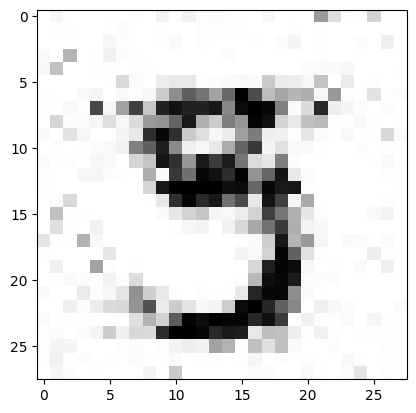

In [40]:
model = load_model('generator_model.h5')

vector = randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()
